In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

#Read the data file
f = h5py.File('data.h5', 'r')

#The images are of shape 20*20
#Each row in X and testX represents an image
#Reshape both arrays, so they are 3D and represents multiple images in 2D format
xTrain = np.reshape(f['X'], (-1, 20, 20))
xTest = np.reshape(f['testX'], (-1, 20, 20))

yTrain = f['y']
yTest = f['testy']

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

2024-07-15 14:55:42.116917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Convert 2D greyscale images into 3D images, so they are compatible with tensorflow
xTrain = np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1],xTrain.shape[2],1))
xTest = np.reshape(xTest,(xTest.shape[0],xTest.shape[1],xTest.shape[2],1))

xTrain.shape

(439452, 20, 20, 1)

In [4]:
yTrain = tf.keras.utils.to_categorical(yTrain,2)
yTest = tf.keras.utils.to_categorical(yTest,2)

In [5]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

In [6]:
#Pre processing the data

#This generator will generate all the images when needed. It will normalise the data (mean - 0, std - 1). It also splits the data into train-validation sets. The validation set size is 20%. This validation set is used for training the neural network and updating weights and biases. 

datagen = ImageDataGenerator(
    rescale=1./255, 
    featurewise_center=True, 
    featurewise_std_normalization=True,
    validation_split=0.2 
    )


batchSize = 36 # no. of samples to be used in each iteration of training the network

datagen.fit(xTrain) #Compute and apply mean/stf normalisation

In [7]:
#Set up training and test data batches

#Set up the training data set
train_generator = datagen.flow(
    xTrain, 
    yTrain, 
    batch_size=batchSize, 
    shuffle=True, 
    subset='training' #since validation set defined above was 20%, this generator takes 80% of the training data
                      
    )

#Set up the validation set
val_generator = datagen.flow(
    xTrain,
    yTrain,
    batch_size=batchSize,
    shuffle=True,
    subset='validation'
    )

#Set up the test set
test_generator =  datagen.flow(
    xTest,
    yTest,
    batch_size=1 #Only test 1 sample at a time
    )

In [9]:
#During training, in each iteration of updating the weights, the validation set is used to calculate the accuracy (no of correct predictions) and loss (difference between correct and predicted values)
#Accuracy should increase, loss should decrease

#During training, if the accuracy increases, save the weights to a local file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "CNNModel.h5", 
    monitor = "val_accuracy", 
    verbose = 1, 
    save_best_only = True,
    mode = 'max'
    )

#During training, if the loss stops decreasing, stop training.
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=1, 
    mode='min', 
    baseline=None, 
    restore_best_weights=False 
)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

logdir = "../logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# collecting all callbacks together
callbacks_list = [checkpoint, earlystopping, lr_scheduler, tensorboard_callback]

In [8]:
model = tf.keras.Sequential() #Create feedforward network

#Convolutional layers are stacked and decrease in the number of filters used. The filters represent what type of feature to look for, while the kernel represents the size of each section the filter is applied to.

#Using multiple consecutive convolutional layers mean each feature gets more distinct and can be easily picked out, especially by the dense layers afterwards.

#First convolutional layer 
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(xTrain[0].shape))
)

#Second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu')
)

model.add(tf.keras.layers.MaxPooling2D((2, 2))) #This layer is used after convolutional layers to reduce the spatial dimensions. This helps to compress the data and pick out key features. 

model.add(tf.keras.layers.Flatten()) #Flatten our input layer into a single column tensor

#Add three hidden layers
#Our input has 20x20 = 400 points
#Output has 2 points (0,1)
#The number of neurons should descend throughout the network and stay in between these values

model.add(tf.keras.layers.Dense(200, activation="relu"))

model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

#Output layer, return the probability of each output response and pick the highest one (softmax)
model.add(tf.keras.layers.Dense(2, activation='softmax'))   

2024-07-15 14:55:50.234145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#Evaluate the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batchSize,
    validation_data=val_generator,
    validation_steps=val_generator.n // batchSize,
    epochs=EPOCHS,
    callbacks=callbacks_list
    )

Epoch 1/10
9762/9765 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9779
Epoch 1: val_accuracy improved from -inf to 0.98556, saving model to CNNModel.h5
9765/9765 [==============================] - 164s 17ms/step - loss: 0.0686 - accuracy: 0.9779 - val_loss: 0.0461 - val_accuracy: 0.9856 - lr: 1.0000e-04
Epoch 2/10
9763/9765 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9882
Epoch 2: val_accuracy improved from 0.98556 to 0.98922, saving model to CNNModel.h5
9765/9765 [==============================] - 166s 17ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0366 - val_accuracy: 0.9892 - lr: 1.0000e-04
Epoch 3/10
9765/9765 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9906
Epoch 3: val_accuracy improved from 0.98922 to 0.98982, saving model to CNNModel.h5
9765/9765 [==============================] - 166s 17ms/step - loss: 0.0311 - accuracy: 0.9906 - val_loss: 0.0329 - val_accuracy: 0.9898 - lr: 1.0000e-0

In [12]:
# load weights
model.load_weights("CNNModel.h5")  #The last set of weights saved should be the one with the best accuracy, so we used this set

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}, test loss: {test_loss}')

146484/146484 [==============================] - 122s 836us/step - loss: 0.0289 - accuracy: 0.9910
Test accuracy: 0.990961492061615, test loss: 0.028900129720568657


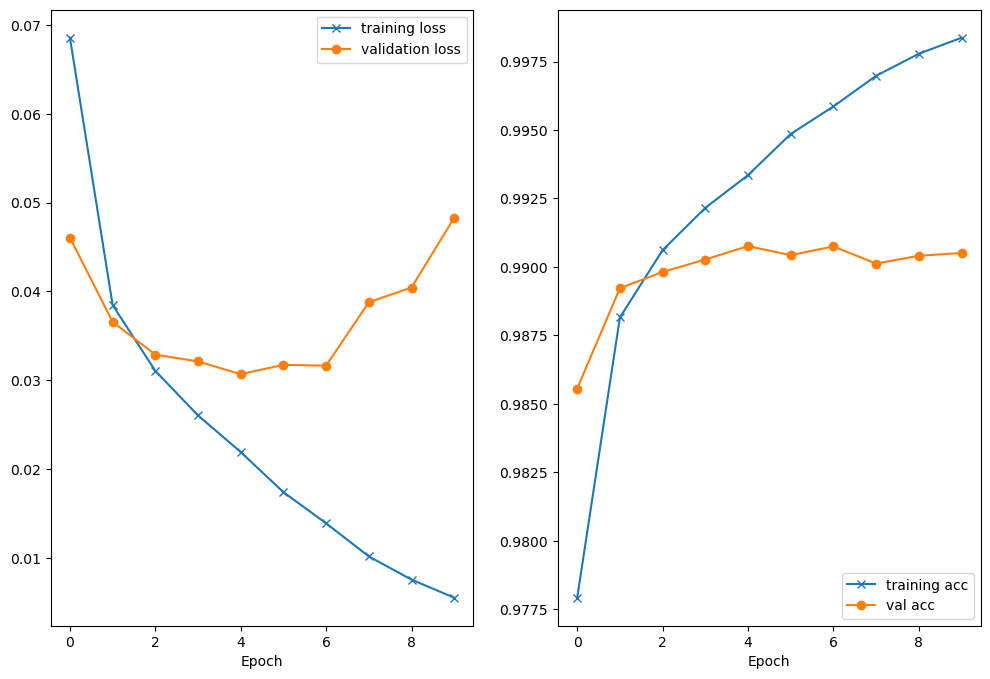

In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'x-', label="training loss", )
plt.plot(history.history['val_loss'], 'o-', label="validation loss")
plt.legend(loc='upper right')
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'x-', label="training acc")
plt.plot(history.history['val_accuracy'], 'o-', label="val acc")
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.show()

In [ ]:
#Overfitting starting at epoch 6